# COVID-19 Analysis

## Preliminaries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import requests
import zipfile
import datetime
from pathlib import Path
from IPython.display import display, Markdown
from functools import reduce

In [42]:
print(f"Generated on {datetime.datetime.utcnow()} UTC")

Generated on 2021-07-27 07:44:51.894355 UTC


## Data retrieval
### Get OurWorldInData data

In [43]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
df.index = pd.to_datetime(df.date)
df["death_ratio"] = df.new_deaths_smoothed_per_million / df.new_cases_smoothed_per_million

### French data

In [44]:
fr_dep_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5")
fr_dep_df.index = pd.to_datetime(fr_dep_df.date)

fr_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617")
fr_df.index = pd.to_datetime(fr_df.date)

/Users/pagessin/default_jupyter_kernel/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Swiss data

In [46]:
r = requests.get("https://www.covid19.admin.ch/api/data/context", timeout=10)
url = r.json()["sources"]["zip"]["csv"]

with tempfile.TemporaryDirectory() as d:
    dl = Path(d) / "dl.zip"
#     print(dl.resolve())
    with requests.get(url, stream=True, timeout=10) as r:
        with dl.open("wb") as fh:
            r.raise_for_status()
            for chunk in r.iter_content(chunk_size=8192): 
                fh.write(chunk)

    with zipfile.ZipFile(fh.name) as z:
        with z.open("data/COVID19Cases_geoRegion.csv") as fh:
            ch_df = pd.read_csv(fh)
            
ch_df.index = pd.to_datetime(ch_df.datum)

In [183]:
r = requests.get("https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Fallzahlen_Inzidenz_aktualisiert.xlsx?__blob=publicationFile", timeout=10)
ger_df = pd.read_excel(r.content, engine='openpyxl', sheet_name="BL_7-Tage-Fallzahl-aktualisiert")
ger_df = ger_df.transpose()
states = list(ger_df.iloc[0][4:])
ger_df = ger_df.iloc[1:]
ger_df = ger_df.drop([0, 1, 3], axis=1)
ger_df.columns = ["date"] + states
ger_df.index = pd.to_datetime(ger_df.date)
ger_df = ger_df.drop("date", axis=1)
ger_df = ger_df.iloc[:np.argmax(ger_df.isna().all(axis=1))] # remove everything after first all-NaN row
ger_df["Germany"] = ger_df.sum(axis=1)
# ger_df
ger_inc_df = ger_df[["Germany"]].copy()
ger_inc_df.Germany *= 1/83_100_000 * 100_000
# ger_inc_df

In [187]:
inc_df = reduce(lambda l, r: l.join(r, how="outer"), [
    fr_dep_df[fr_dep_df.lib_dep == "Ain"][["tx_incid"]].rename(columns={"tx_incid": "Ain"}),
    fr_df[["tx_incid"]].rename(columns={"tx_incid": "France"}),
    ch_df[ch_df.geoRegion == "GE"][["inzsum7d"]].rename(columns={"inzsum7d": "Geneva"}),
    ch_df[ch_df.geoRegion == "VD"][["inzsum7d"]].rename(columns={"inzsum7d": "Vaud"}),
    ch_df[ch_df.geoRegion == "CH"][["inzsum7d"]].rename(columns={"inzsum7d": "Switzerland"}),
    ger_inc_df,
])

## Incidences

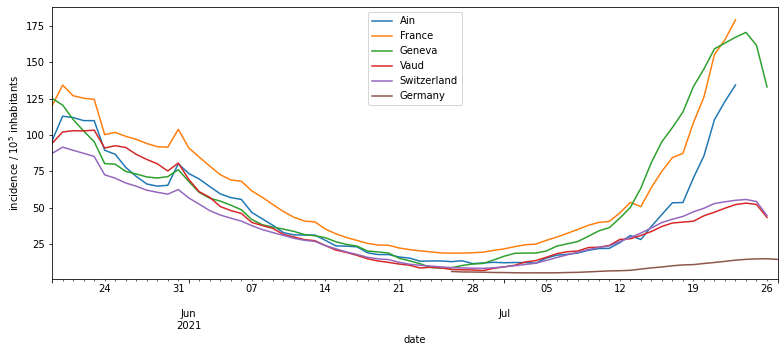

,Ain,France,Geneva,Vaud,Switzerland,Germany
2021-07-07,17.961656,32.380245,25.19,19.75,17.63,5.460890
2021-07-08,18.874961,35.092009,26.78,20.25,19.32,5.590854
2021-07-09,20.701570,37.915521,30.35,22.61,21.21,5.896510
2021-07-10,21.919310,39.894214,34.12,22.85,22.66,6.233454
2021-07-11,22.071527,40.610895,36.30,24.10,23.73,6.572804
2021-07-12,26.029180,46.451616,42.85,28.20,26.75,6.694344
2021-07-13,30.900138,53.695899,50.19,28.69,29.48,6.975933
2021-07-14,28.160224,50.785968,63.48,30.93,32.58,7.835138
2021-07-15,37.141052,63.862033,81.13,33.66,36.11,8.630566
2021-07-16,45.360793,75.117342,95.41,37.14,39.82,9.290012


In [189]:
fig, ax = plt.subplots(figsize=(13,5))
inc_df[inc_df.index > datetime.datetime.now() - datetime.timedelta(weeks=10)].plot(ax=ax)
# inc_df.tail(7*8).plot(ax=ax)
# ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlabel("date")
ax.set_ylabel("incidence / $10^5$ inhabitants")
plt.show()
display(inc_df.tail(21))

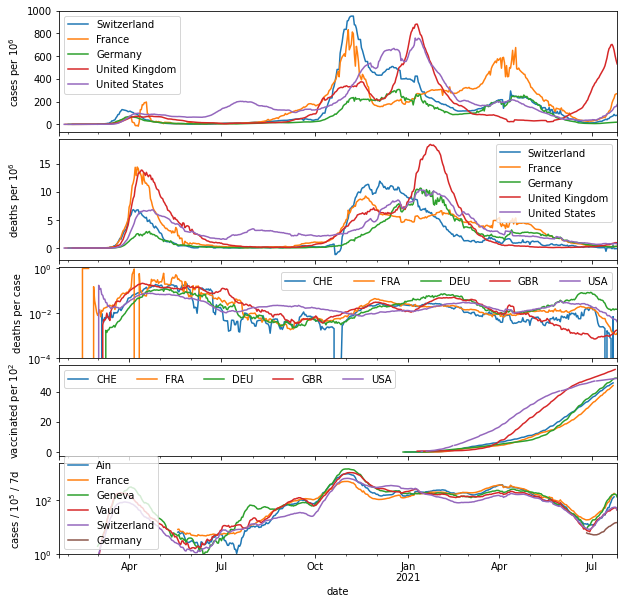

In [179]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 1, 0.75, 0.75, 0.75], "hspace": 0.07}, sharex=True)
ax1, ax2, ax3, ax4, ax5 = axs
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
):
    cdf = df[df.iso_code == country]
    
    name = cdf.location[0]
    cdf.plot(y="new_cases_smoothed_per_million", ax=ax1, label=name)
    cdf.plot(y="new_deaths_smoothed_per_million", ax=ax2, label=name)
   
    cdf.plot(y="death_ratio", ax=ax3, label=country)
    
    cdf.plot(y="people_fully_vaccinated_per_hundred", ax=ax4, label=f"{country}")
#     cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, ls="--", c=ax3.get_lines()[-1].get_color(), label=f"total")


# fr_dep_df[fr_dep_df.lib_dep == "Ain"].plot(y="tx_incid", ax=ax5, label="Ain")
# fr_df.plot(y="tx_incid", ax=ax5, label="France")
# ch_df[ch_df.geoRegion == "GE"].plot(y="inzsum7d", ax=ax5, label="Geneva")
# ch_df[ch_df.geoRegion == "VD"].plot(y="inzsum7d", ax=ax5, label="Vaud")
# ch_df[ch_df.geoRegion == "CH"].plot(y="inzsum7d", ax=ax5, label="Switzerland")
inc_df.plot(ax=ax5)
ax5.set_yscale("log")
ax5.set_ylim(bottom=1)

ax5.set_xlabel("date")
ax5.set_ylabel("cases / $10^5$ / 7d")

ax4.legend(ncol=5)
ax3.legend(ncol=5)

ax3.set_ylim(bottom=1e-4)
ax3.set_yscale("log")

ax1.set_ylabel("cases per $10^6$")
ax2.set_ylabel("deaths per $10^6$")
ax3.set_ylabel("deaths per case")
ax4.set_ylabel("vaccinated per $10^2$")

fig.align_ylabels()
# fig.tight_layout()
plt.show()

### Switzerland

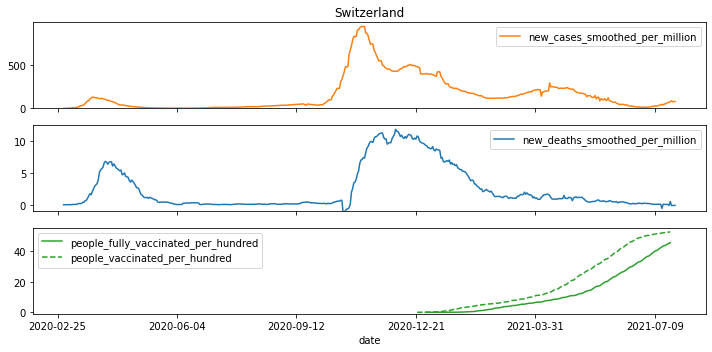

### France

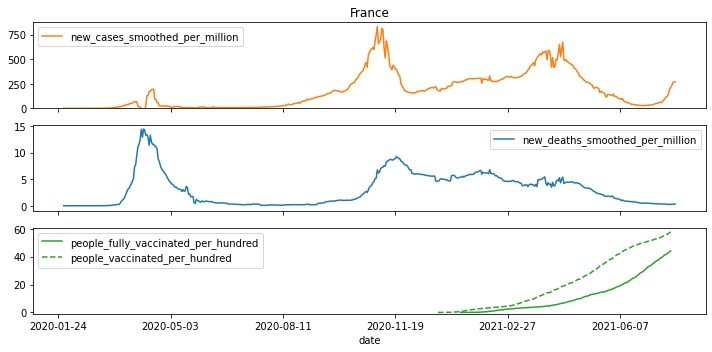

### Germany

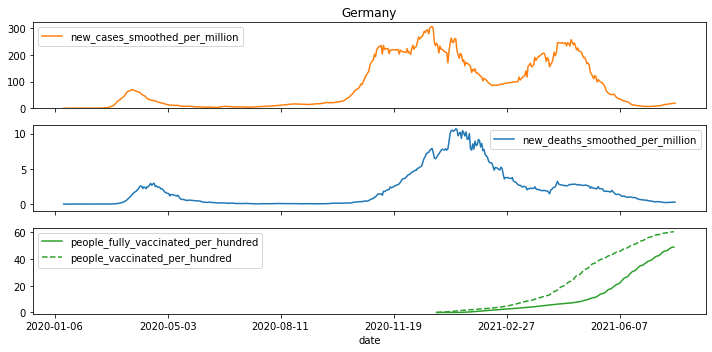

### United Kingdom

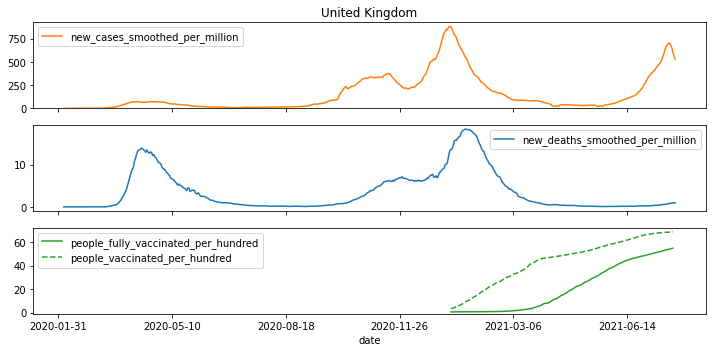

### United States

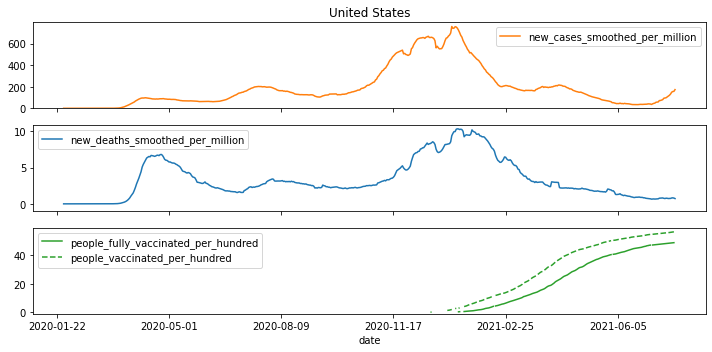

### Greece

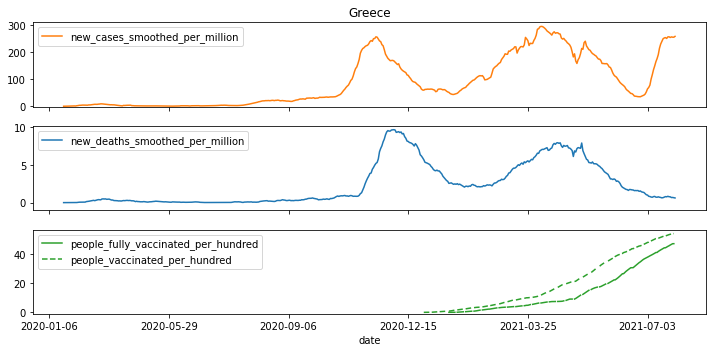

In [95]:
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
    "GRC"
):
    cdf = df[df.iso_code == country]
    display(Markdown(f"### {cdf.location[0]}"))
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
    ax1, ax2, ax3 = axs
    cdf.plot("date", "new_cases_smoothed_per_million", ax=ax1, c="tab:orange")
    cdf.plot("date", "new_deaths_smoothed_per_million", ax=ax2, c="tab:blue")
    cdf.plot("date", "people_fully_vaccinated_per_hundred", ax=ax3, c="tab:green")
    cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, c="tab:green", ls="--")
    
    for ax in axs:
        ax.set_ylim(bottom=-1)

    ax1.set_title(cdf.location[0])
    fig.tight_layout()
    plt.show()